## Prep

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [35]:
# shane's logs
filepath_shane = '/Users/danielhustert/Documents/Uni/GT/Courses/DL/DiamondsInTheRough/log_parser/logs/shane_logs/'

# nico's logs
filepath_nico = '/Users/danielhustert/Documents/Uni/GT/Courses/DL/DiamondsInTheRough/log_parser/logs/nico_logs/'

# bre's logs
#filepath = '/home/shane/minerl/logs/bre_logs/'

# daniel's logs
filepath = '/Users/danielhustert/Documents/Uni/GT/Courses/DL/DiamondsInTheRough/log_parser/logs/daniel_logs/'

In [36]:
rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:result/.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n"),
    'eval': re.compile(r"evaluation (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}

def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

## Pretraining detailed

In [6]:
# Get data 
statistics = []
rewards = []

with open(f"{filepath}pretrain_25/log.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_statistics = pd.DataFrame(statistics).apply(pd.to_numeric)

# df_reward.drop_duplicates(keep='first', inplace=True)
df_statistics.drop_duplicates(keep='first', inplace=True)


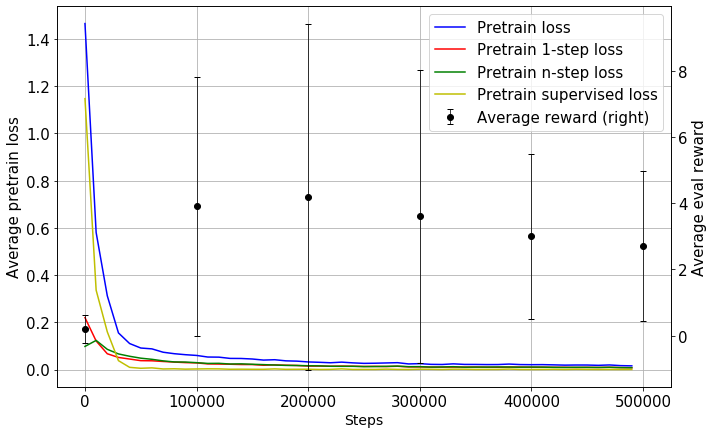

In [14]:
# Create plot
fig, ax = plt.subplots(figsize=(11,7))
l1 = ax.plot(df_statistics.n_updates, df_statistics.average_loss, label = 'Pretrain loss', color='b')
l2 = ax.plot(df_statistics.n_updates, df_statistics.average_loss_1step, label = 'Pretrain 1-step loss', color='r')
l3 = ax.plot(df_statistics.n_updates, df_statistics.average_loss_nstep, label = 'Pretrain n-step loss', color='g')
l4 = ax.plot(df_statistics.n_updates, df_statistics.average_loss_supervised, label = 'Pretrain supervised loss', color='y')

# Evaluations
x = [0, 100000, 200000, 300000, 400000, 500000]
evals = [0.2, 3.9, 4.2, 3.6, 3.0, 2.7]
stdev = [0.42, 3.900142447541001, 5.223876806442596, 4.427188724235731, 2.494438257849294, 2.263232692902394]
ax2 = ax.twinx()
l5 = ax2.errorbar(x, evals, yerr=stdev, fmt='o', label='Average reward (right)', elinewidth=0.75, capsize=3, color='k')

# Create legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
labs = l1 + l2
hs = h1 + h2
ax.legend(hs, labs, fontsize=15)

#  ax.set_title("Average pretrain loss and reward by training steps", fontsize=20)
ax.set_xlabel('Steps', fontsize=14)
ax.set_ylabel('Average pretrain loss', fontsize=15)
ax2.set_ylabel('Average eval reward', fontsize=15)
ax.grid()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
# fig.tight_layout()
plt.savefig('pretrain_losses.png')


## Pretraining comparison

In [15]:
# Get data 
n_experts = [10, 25, 50, 100]
dict_reward = {}
dict_statistics = {}

for e in n_experts:
    statistics = []
    rewards = []
    fp = filepath + 'pretrain_' + str(e)  
    with open(f"{fp}/log.txt", 'r') as f:
        for line in f:
            key, match = _parse_line(line)
            if key == 'statistics':
                # replace nan with 0
                stats = match.group('statistics').replace('nan', '0.0')
                # convert the list of tuples into a dict
                statistics.append(dict(eval(stats)))
                
            if key == 'result':
                result = match.group('result').replace('nan', '0.0').split()
                rewards.append(dict(map(lambda s : s.split(':'), result)))
                # the dict values are strings, should be int. convert here, or in dataframe?
                #print(step, episode, reward)
    
    df_reward = pd.DataFrame(rewards).apply(pd.to_numeric)
    df_statistics = pd.DataFrame(statistics).apply(pd.to_numeric)

    df_reward.drop_duplicates(keep='first', inplace=True)
    df_statistics.drop_duplicates(keep='first', inplace=True)

    dict_reward[e] = df_reward
    dict_statistics[e] = df_statistics

In [28]:
dict_statistics[10]

,average_loss_1step,average_loss_nstep,average_loss_supervised,average_loss,n_updates
0,0.157012,0.132489,1.175386,1.464886,1
2,0.121221,0.129256,0.112112,0.362589,10001
4,0.067989,0.073632,0.006623,0.148243,20001
6,0.043316,0.044998,0.002072,0.090386,30001
8,0.036260,0.040623,0.001659,0.078542,40001
10,0.032592,0.035568,0.000957,0.069117,50001
12,0.027929,0.031081,0.000841,0.059851,60001
14,0.025186,0.026788,0.001205,0.053179,70001
16,0.023974,0.025138,0.000609,0.049721,80001
18,0.019566,0.022786,0.000540,0.042892,90001


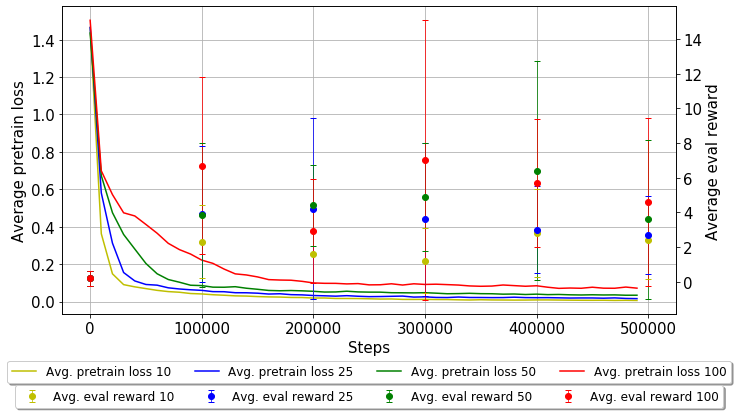

In [30]:
# Create plot
fig, ax = plt.subplots(figsize=(11,7))
ax2 = ax.twinx()
x = [0, 100000, 200000, 300000, 400000, 500000]
lns = []

# Manually insert
evaluations = {10: [0.2, 2.3, 1.6, 1.2, 2.8, 2.4], 
               25: [0.2, 3.9, 4.2, 3.6, 3.0, 2.7], 
               50: [0.2, 3.85, 4.4, 4.9, 6.4, 3.6], 
               100: [0.2, 6.7, 2.9, 7, 5.7, 4.6]}
stdev = {10: [0.42, 2.110818693198342, 2.590581230363393, 1.8737959096740262, 2.5298221281347035, 2.2211108331943574], 
         25: [0.42, 3.900142447541001, 5.223876806442596, 4.427188724235731, 2.494438257849294, 2.263232692902394], 
         50: [0.42, 4.148627617792552, 2.3190036174568114, 3.1073389830457114, 6.328067986711619, 4.59951688284], 
         100: [0.42, 5.1001089312985375, 2.998147576235848, 8.082903768654761, 3.7133393177689658, 4.835057163858332]}
cols = {10: 'y', 25: 'b', 50: 'g', 100: 'r'}

for e in n_experts: 
    # Pretraining
    a = ax.plot(dict_statistics[e].n_updates, dict_statistics[e].average_loss, color=cols[e], label = 'Avg. pretrain loss ' + str(e))
    lns += a

    # Evaluations
    evals = evaluations[e]
    stds = stdev[e]
    b = ax2.errorbar(x, evals, yerr=stds, fmt='o', label='Avg. eval reward ' + str(e), color=cols[e], elinewidth=0.75, capsize=3)
    lns += b

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=5, fontsize=12)

# Shrink current axis's height by 10% on the bottom
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0 + box2.height * 0.1,
                 box2.width, box2.height * 0.9])

# Put a legend below current axis
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.21),
          fancybox=True, shadow=True, ncol=5, fontsize=12)

# ax.set_title("Average pretrain loss and reward by training steps", fontsize=20)
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average pretrain loss', fontsize=15)
ax2.set_ylabel('Average eval reward', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax.grid()
plt.savefig('pretrain_comparison.png')

## DQFD

In [40]:
# Training dqfd

# First log file
statistics = []
rewards = []

with open(f"{filepath}pretrain_dqfd/log_1.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_1 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_1 = pd.DataFrame(statistics).apply(pd.to_numeric)

# Remove duplicates
df_reward_1.drop_duplicates(keep='first', inplace=True)
df_statistics_1.drop_duplicates(keep='first', inplace=True)

df_train_1 = df_reward_1.join(df_statistics_1)

# Cut out learning after last saved model
df_train_1 = df_train_1[:151]

###
# Second log file
statistics = []
rewards = []
with open(f"{filepath}pretrain_dqfd/log_2.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_2 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_2 = pd.DataFrame(statistics).apply(pd.to_numeric)

# Remove duplicates
df_reward_2.drop_duplicates(keep='first', inplace=True)
df_statistics_2.drop_duplicates(keep='first', inplace=True)

df_train_2 = df_reward_2.join(df_statistics_2)

# Cut out learning after last saved model
df_train_2 = df_train_2[:151]


###
# Third log file
statistics = []
rewards = []
with open(f"{filepath}pretrain_dqfd/log_3.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_3 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_3 = pd.DataFrame(statistics).apply(pd.to_numeric)

df_reward_3.drop_duplicates(keep='first', inplace=True)
df_statistics_3.drop_duplicates(keep='first', inplace=True)

df_train_3 = df_reward_3.join(df_statistics_3)

# Cut out learning after last saved model
df_train_3 = df_train_3[:178]


###
# Fourth log file
statistics = []
rewards = []
with open(f"{filepath}pretrain_dqfd/log_4.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_4 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_4 = pd.DataFrame(statistics).apply(pd.to_numeric)

# Remove duplicates
df_reward_4.drop_duplicates(keep='first', inplace=True)
df_statistics_4.drop_duplicates(keep='first', inplace=True)

df_train_4 = df_reward_4.join(df_statistics_4)

# Cut out learning after last saved model
# TODO!!
# df_train_4 = df_train_4[:178]

###
# Fifth log file
statistics = []
rewards = []
with open(f"{filepath}pretrain_dqfd/log_5.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_5 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_5 = pd.DataFrame(statistics).apply(pd.to_numeric)

# Remove duplicates
df_reward_5.drop_duplicates(keep='first', inplace=True)
df_statistics_5.drop_duplicates(keep='first', inplace=True)

df_train_5 = df_reward_5.join(df_statistics_5)

# Cut out learning after last saved model
# TODO!!
# df_train_4 = df_train_4[:178]

###
# baseline
statistics = []
rewards = []
with open(f"{filepath_shane}log.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_base = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_base = pd.DataFrame(statistics).apply(pd.to_numeric)

df_train_base = df_reward_base.join(df_statistics_base)

###
# pretrained PDDDQN
statistics = []
rewards = []
with open(f"{filepath_nico}/dfdq_pretrain/log.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_pdddqn = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_pdddqn = pd.DataFrame(statistics).apply(pd.to_numeric)

df_train_pdddqn = df_reward_pdddqn.join(df_statistics_pdddqn)

###
# Concat
episodes_1 = int(df_train_1.episode[-1:])
episodes_2 = int(df_train_2.episode[-1:])
episodes_3 = int(df_train_3.episode[-1:])
episodes_4 = int(df_train_4.episode[-1:])
episodes_5 = int(df_train_5.episode[-1:])

steps_1 = int(df_train_1.step[-1:])
steps_2 = int(df_train_2.step[-1:])
steps_3 = int(df_train_3.step[-1:])
steps_4 = int(df_train_4.step[-1:])
steps_5 = int(df_train_5.step[-1:])

n_updates_1 = int(df_train_1.n_updates[-1:])
n_updates_2 = int(df_train_2.n_updates[-1:])
n_updates_3 = int(df_train_3.n_updates[-1:])
n_updates_4 = int(df_train_4.n_updates[-1:])
n_updates_5 = int(df_train_5.n_updates[-1:])

df_train_2['episode'] += episodes_1 + 1
df_train_2['step'] += steps_1 + 1
df_train_2['n_updates'] += n_updates_1 + 1

df_train_3['episode'] += episodes_1 + 1 + episodes_2 + 1
df_train_3['step'] += steps_1 + 1 + steps_2 + 1
df_train_3['n_updates'] += n_updates_1 + 1 + n_updates_2 + 1

df_train_4['episode'] += episodes_1 + 1 + episodes_2 + 1 + episodes_3 + 1
df_train_4['step'] += steps_1 + 1 + steps_2 + 1 + steps_3 + 1
df_train_4['n_updates'] += n_updates_1 + 1 + n_updates_2 + 1 + n_updates_3 + 1

df_train_5['episode'] += episodes_1 + 1 + episodes_2 + 1 + episodes_3 + 1 + episodes_4 + 1
df_train_5['step'] += steps_1 + 1 + steps_2 + 1 + steps_3 + 1 + steps_4 + 1
df_train_5['n_updates'] += n_updates_1 + 1 + n_updates_2 + 1 + n_updates_3 + 1 + n_updates_4 + 1

df_train = pd.concat([df_train_1, df_train_2, df_train_3, df_train_4, df_train_5])


In [41]:
df_train

,step,episode,R,average_loss_1step,average_loss_nstep,average_loss_supervised,average_loss,n_updates
0,2000,0,0.0,0.220777,0.262876,0.505449,0.989102,500
2,4000,1,0.0,0.166023,0.211626,0.437048,0.814697,1000
4,6000,2,0.0,0.130795,0.193174,0.399649,0.723619,1500
6,8000,3,2.0,0.117520,0.165107,0.374587,0.657213,2000
8,10000,4,3.0,0.109200,0.156793,0.333441,0.599434,2500
...,...,...,...,...,...,...,...,...
260,1731373,882,48.0,0.015685,0.043936,0.001648,0.061270,432845
262,1733373,883,21.0,0.017657,0.041856,0.000691,0.060205,433345
264,1735373,884,55.0,0.016184,0.044058,0.002015,0.062257,433845
266,1736788,885,64.0,0.016193,0.046344,0.004008,0.066545,434199


In [42]:
df_train.to_csv('daniel_log.txt')

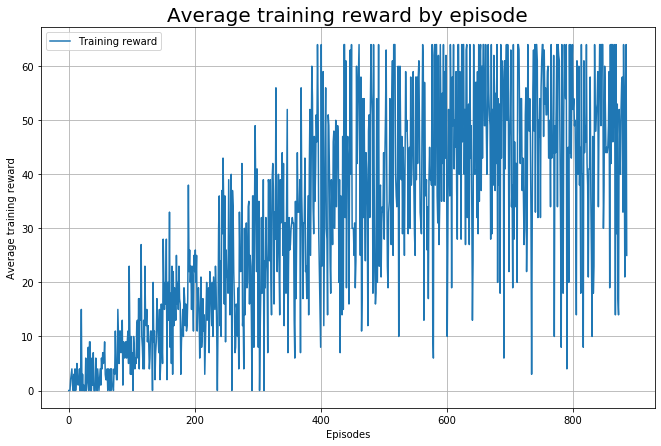

In [43]:
# Plot
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(df_train.episode, df_train.R, label = 'Training reward')
# ax.plot(df_train_base.episode, df_train_base.R, label = 'Training reward')

ax.set_title("Average training reward by episode", fontsize=20)
ax.set_xlabel('Episodes')
ax.set_ylabel('Average training reward')
ax.legend()
ax.grid()

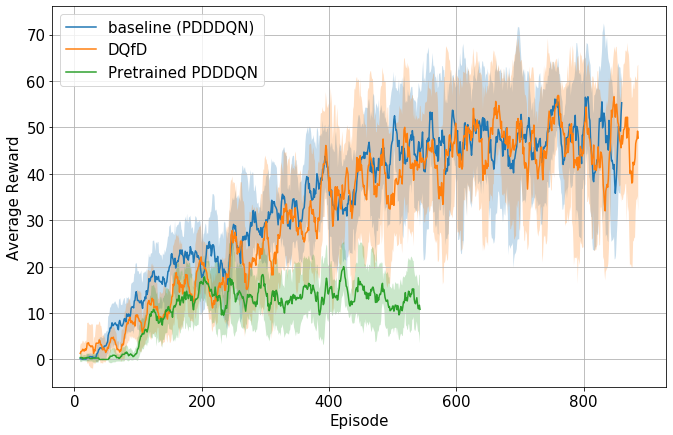

In [48]:
window = 10

# baseline
mean_base = df_train_base['R'].rolling(window).mean()
sigma_base = df_train_base['R'].rolling(window).std()

# DQfD
mean = df_train['R'].rolling(window).mean()
sigma = df_train['R'].rolling(window).std()

# Pretrained PDDDQN
mean_pdddqn = df_train_pdddqn['R'].rolling(window).mean()
sigma_pdddqn = df_train_pdddqn['R'].rolling(window).std()

fig, ax = plt.subplots(figsize=(11,7))

# baseline
ax.plot(df_train_base.episode, mean_base, label='baseline (PDDDQN)')
ax.fill_between(df_train_base.episode, mean_base+sigma_base, mean_base-sigma_base, alpha=0.25)

# DqfD
ax.plot(df_train.episode, mean, label='DQfD')
ax.fill_between(df_train.episode, mean+sigma, mean-sigma, alpha=0.25)

# pretrained PDDDQN
ax.plot(df_train_pdddqn.episode, mean_pdddqn, label='Pretrained PDDDQN')
ax.fill_between(df_train_pdddqn.episode, mean_pdddqn+sigma_pdddqn, mean_pdddqn-sigma_pdddqn, alpha=0.25)

# ax.vlines(episodes_1, ymin=0, ymax=70, linestyles='dotted')
# ax.vlines(episodes_1 + episodes_2, ymin=0, ymax=70, linestyles='dotted')
# ax.vlines(episodes_1 + episodes_2 + episodes_3, ymin=0, ymax=70, linestyles='dotted')
# ax.vlines(episodes_1 + episodes_2 + episodes_3 + episodes_4, ymin=0, ymax=70, linestyles='dotted')
# ax.vlines(episodes_1 + episodes_2 + episodes_3 + episodes_4 + episodes_5, ymin=0, ymax=70, linestyles='dotted')

# ax.set_title("Rolling average training reward by episode", fontsize=20)
ax.legend(loc='upper left', fontsize=15)
ax.set_xlabel('Episode', fontsize=15)
ax.set_ylabel('Average Reward', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.grid()

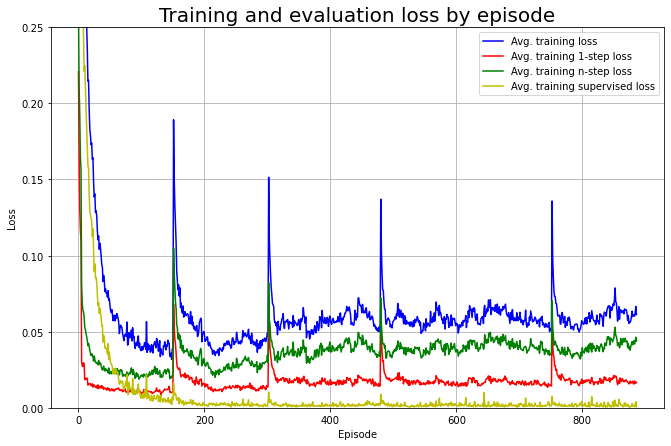

In [37]:
#method 2, plot with dots. I like this more

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_train.episode, df_train.average_loss, label = 'Avg. training loss', color='b')
ax.plot(df_train.episode, df_train.average_loss_1step, label = 'Avg. training 1-step loss', color='r')
ax.plot(df_train.episode, df_train.average_loss_nstep, label = 'Avg. training n-step loss', color='g')
ax.plot(df_train.episode, df_train.average_loss_supervised, label = 'Avg. training supervised loss', color='y')

# ax.plot(df_train.episode, eval_loss, 'o-', label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
plt.ylim((0, 0.25))
ax.grid()

In [38]:
# Get scores
df_scores_1 = pd.read_csv(f"{filepath}pretrain_dqfd/run_1/scores.txt", sep="\t")
df_scores_2 = pd.read_csv(f"{filepath}pretrain_dqfd/run_2/scores.txt", sep="\t")
df_scores_3 = pd.read_csv(f"{filepath}pretrain_dqfd/run_3/scores.txt", sep="\t")
df_scores_4 = pd.read_csv(f"{filepath}pretrain_dqfd/run_4/scores.txt", sep="\t")
df_scores_5 = pd.read_csv(f"{filepath}pretrain_dqfd/run_5/scores.txt", sep="\t")

# prepend with e_ to signify evaluation
df_scores_1.columns = ['e_'+s for s in list(df_scores_1.columns)]
df_scores_2.columns = ['e_'+s for s in list(df_scores_2.columns)]
df_scores_3.columns = ['e_'+s for s in list(df_scores_3.columns)]
df_scores_4.columns = ['e_'+s for s in list(df_scores_4.columns)]
df_scores_5.columns = ['e_'+s for s in list(df_scores_5.columns)]

# Align
df_scores_2['e_episodes'] += episodes_1 + 1
df_scores_2['e_steps'] += steps_1 + 1
df_scores_2['e_n_updates'] += n_updates_1 + 1

df_scores_3['e_episodes'] += episodes_1 + 1 + episodes_2 + 1
df_scores_3['e_steps'] += steps_1 + 1 + steps_2 + 1
df_scores_3['e_n_updates'] += n_updates_1 + 1 + n_updates_2 + 1

df_scores_4['e_episodes'] += episodes_1 + 1 + episodes_2 + 1 + episodes_3 + 1
df_scores_4['e_steps'] += steps_1 + 1 + steps_2 + 1 + steps_3 + 1
df_scores_4['e_n_updates'] += n_updates_1 + 1 + n_updates_2 + 1 + n_updates_3 + 1

df_scores_5['e_episodes'] += episodes_1 + 1 + episodes_2 + 1 + episodes_3 + 1 + episodes_4 + 1
df_scores_5['e_steps'] += steps_1 + 1 + steps_2 + 1 + steps_3 + 1 + steps_4 + 1
df_scores_5['e_n_updates'] += n_updates_1 + 1 + n_updates_2 + 1 + n_updates_3 + 1 + n_updates_4 + 1

df_scores = pd.concat([df_scores_1, df_scores_2, df_scores_3, df_scores_4, df_scores_5])
df_joined = df_train.join(df_scores.set_index('e_steps'), on='step')
df_scores

,e_steps,e_episodes,e_elapsed,e_mean,e_median,e_stdev,e_max,e_min,e_average_loss_1step,e_average_loss_nstep,e_average_loss_supervised,e_average_loss,e_n_updates
0,50000,25,6911.422475,1.000000,0.0,1.732051,3.0,0.0,0.015090,0.030710,0.102331,0.148131,12500
1,100000,50,13782.133568,4.000000,6.0,3.464102,6.0,0.0,0.012542,0.022396,0.036648,0.071586,25000
2,150000,75,20734.309789,3.000000,4.0,1.732051,4.0,1.0,0.012626,0.021751,0.013850,0.048227,37500
3,200000,100,27645.617183,7.333333,5.0,6.806859,15.0,2.0,0.010177,0.021186,0.006240,0.037603,50000
4,251691,126,35215.206578,9.666667,11.0,3.214550,12.0,6.0,0.010797,0.025763,0.008318,0.044878,62922
5,301691,151,42529.771684,19.000000,18.0,4.582576,24.0,15.0,0.011073,0.022035,0.005007,0.038115,75422
6,351691,176,50124.257750,11.666667,14.0,4.041452,14.0,7.0,0.012657,0.026578,0.002825,0.042060,87922
0,351692,176,7225.056064,10.000000,7.0,8.888194,20.0,3.0,0.021011,0.034531,0.003420,0.058962,87923
1,401692,201,14500.449924,27.666667,24.0,12.897028,42.0,17.0,0.015723,0.030492,0.001626,0.047840,100423
2,453455,227,21956.122109,14.000000,13.0,5.567764,20.0,9.0,0.012054,0.023772,0.002637,0.038463,113363


In [39]:
df_scores.to_csv('daniel_scores.txt')

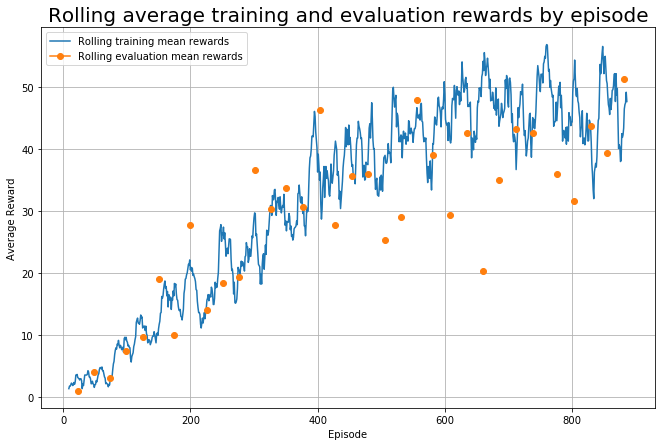

In [149]:
window = 10

train_mean = df_joined['R'].rolling(window).mean()
#one method, interpolate to skip over nans
eval_mean = df_joined['e_mean']

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_mean, label = 'Rolling training mean rewards')
ax.plot(df_joined.episode, eval_mean, 'o-', label='Rolling evaluation mean rewards')
ax.set_title("Rolling average training and evaluation rewards by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

## PDDDQN (not updated)

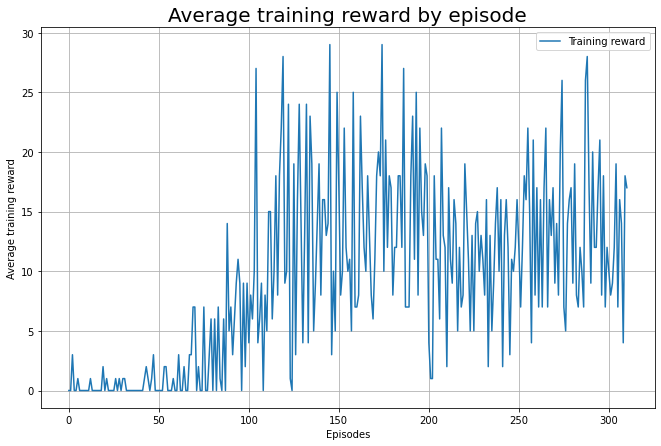

In [12]:
# First 30 or so eps before crash
statistics = []
rewards = []

with open(f"{filepath}500k_25/pdddqn_train.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

          
df_reward_1 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_1 = pd.DataFrame(statistics).apply(pd.to_numeric)

df_reward_1.drop_duplicates(keep='first', inplace=True)
df_statistics_1.drop_duplicates(keep='first', inplace=True)

# Remaining episodes #1
statistics = []
rewards = []

with open(f"{filepath}500k_25/pdddqn_train_3.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

df_reward_2 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_2 = pd.DataFrame(statistics).apply(pd.to_numeric)

df_reward_2.drop_duplicates(keep='first', inplace=True)
df_statistics_2.drop_duplicates(keep='first', inplace=True)

# Concat
new_episode_count = np.arange(38, 38 + df_reward_2.shape[0])
new_step_count = np.arange(78000, 78000 + df_reward_2.shape[0] * 2000, 2000)
df_reward_2['episode'] = new_episode_count
df_reward_2['step'] = new_step_count

df_reward = pd.concat([df_reward_1, df_reward_2])

# Remaining episodes # 2
statistics = []
rewards = []

with open(f"{filepath}500k_25/pdddqn_train_4.txt", 'r') as f:
    for line in f:
        key, match = _parse_line(line)
        if key == 'statistics':
            # replace nan with 0
            stats = match.group('statistics').replace('nan', '0.0')
            # convert the list of tuples into a dict
            statistics.append(dict(eval(stats)))
            
        if key == 'result':
            result = match.group('result').replace('nan', '0.0').split()
            rewards.append(dict(map(lambda s : s.split(':'), result)))
            # the dict values are strings, should be int. convert here, or in dataframe?
            #print(step, episode, reward)

df_reward_3 = pd.DataFrame(rewards).apply(pd.to_numeric)
df_statistics_3 = pd.DataFrame(statistics).apply(pd.to_numeric)

df_reward_3.drop_duplicates(keep='first', inplace=True)
df_statistics_3.drop_duplicates(keep='first', inplace=True)

# Concat
new_episode_count = np.arange(197, 197 + df_reward_3.shape[0])
new_step_count = np.arange(394000, 394000 + df_reward_3.shape[0] * 2000, 2000)
df_reward_3['episode'] = new_episode_count
df_reward_3['step'] = new_step_count

df_reward = pd.concat([df_reward, df_reward_3])







# Generate plot
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(df_reward.episode, df_reward.R, label = 'Training reward')

ax.set_title("Average training reward by episode", fontsize=20)
ax.set_xlabel('Episodes')
ax.set_ylabel('Average training reward')
ax.legend()
ax.grid()

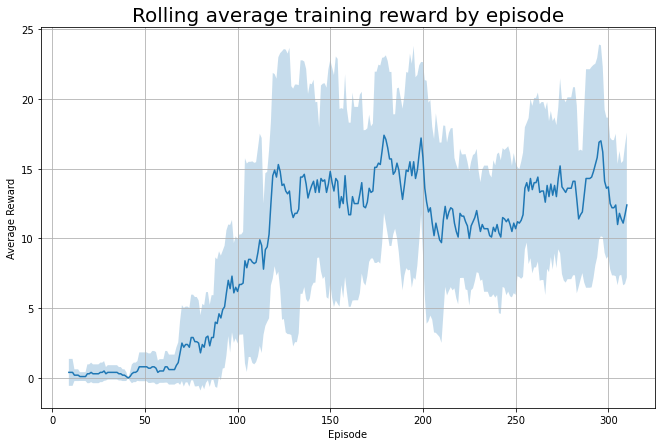

In [13]:
window = 10

mean = df_reward['R'].rolling(window).mean()
sigma = df_reward['R'].rolling(window).std()

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_reward.episode, mean, label='Average reward')
ax.fill_between(df_reward.episode, mean+sigma, mean-sigma, alpha=0.25)
ax.set_title("Rolling average training reward by episode", fontsize=20)
#ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

## Not used

In [ ]:
fig, ax = plt.subplots(figsize=(11,7))

ax.plot(df_reward.episode, df_reward.average_q, label = 'Average q value')
ax.set_title("Average Q value by training episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Q Value')
ax.grid()

In [ ]:
window = 10

mean = df_train['R'].rolling(window).mean()
sigma = df_train['R'].rolling(window).std()


fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df.episode, mean, label='Average reward')
ax.fill_between(df.episode, mean+sigma, mean-sigma, alpha=0.25)
ax.set_title("Rolling average training reward by episode", fontsize=20)
#ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [120]:
df_scores = pd.read_csv(f"{filepath}pretrain_dqfd/run_1/scores.txt", sep="\t")
# prepend with e_ to signify evaluation
df_scores.columns = ['e_'+s for s in list(df_scores.columns)]
df_joined = df_train.join(df_scores.set_index('e_steps'), on='step')

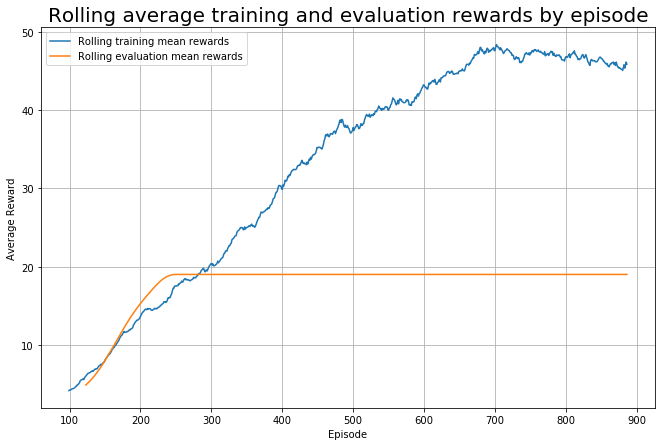

In [124]:
window = 100

train_mean = df_joined['R'].rolling(window).mean()
#one method, interpolate to skip over nans
eval_mean = df_joined['e_mean'].interpolate(method='linear').rolling(window).mean()

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_mean, label = 'Rolling training mean rewards')
ax.plot(df_joined.episode, eval_mean, label='Rolling evaluation mean rewards')
ax.set_title("Rolling average training and evaluation rewards by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [ ]:
df_scores

,e_steps,e_episodes,e_elapsed,e_mean,e_median,e_stdev,e_max,e_min,e_average_q,e_average_loss,e_cumulative_steps,e_n_updates,e_rlen
0,151359,153,17929.546328,-14.276875,-16.605597,23.306074,27.145649,-51.026719,131.36403,1.912841,151359,36590,151359
1,300836,308,36825.814299,-24.645416,-21.171753,36.804569,26.639973,-96.306236,276.37677,4.910460,300836,73960,300000
2,450033,456,56030.610398,-0.476819,-6.456629,38.887919,144.680854,-39.142479,504.12363,7.457492,450033,111259,300000
3,601106,598,79717.889257,-9.344816,-7.980667,31.386551,50.282701,-67.118317,745.63885,12.086363,601106,149027,300000
4,750156,749,99309.454166,-22.893548,-10.307964,44.596432,30.906282,-127.931580,1087.81380,16.479201,750156,186290,300000
5,900838,902,119181.000124,-4.497449,-5.300489,31.617537,39.352953,-88.464684,2213.66380,38.337676,900838,223960,300000
